In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import seaborn as sns

import random
from collections import deque

plt.style.use('ggplot')

import sys 
sys.path.append('..')


In [93]:
df = pd.read_csv("../data/ChargePoint Data CY20Q4_fixed_dates.csv", index_col=0)
df = df[df['End Date'] >= '2017-01-01']
df_webster = df[df.Cluster == 'WEBSTER']

pred_webster = pd.read_csv('../predictions/best_sweep_tgcn_cpnll_7ky8scku_dynamic_2/predictions_TGCN_WEBSTER_apricot-music-5986.csv', index_col=0)
pred_webster = pred_webster.iloc[:2831]

In [94]:

df_webster['DayOfWeek'] = df_webster['Start Date'].apply(lambda x: pd.to_datetime(x).dayofweek)
df_webster['Hour'] = df_webster['Start Date'].apply(lambda x: pd.to_datetime(x).hour)
pred_webster['DayOfWeek'] = pred_webster['Date'].apply(lambda x: pd.to_datetime(x).dayofweek)
pred_webster['Hour'] = pred_webster['Date'].apply(lambda x: pd.to_datetime(x).hour)


/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_5112/1712817899.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_webster['DayOfWeek'] = df_webster['Start Date'].apply(lambda x: pd.to_datetime(x).dayofweek)
/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_5112/1712817899.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_webster['Hour'] = df_webster['Start Date'].apply(lambda x: pd.to_datetime(x).hour)


<AxesSubplot:xlabel='Hour', ylabel='WEBSTER_1_pred'>

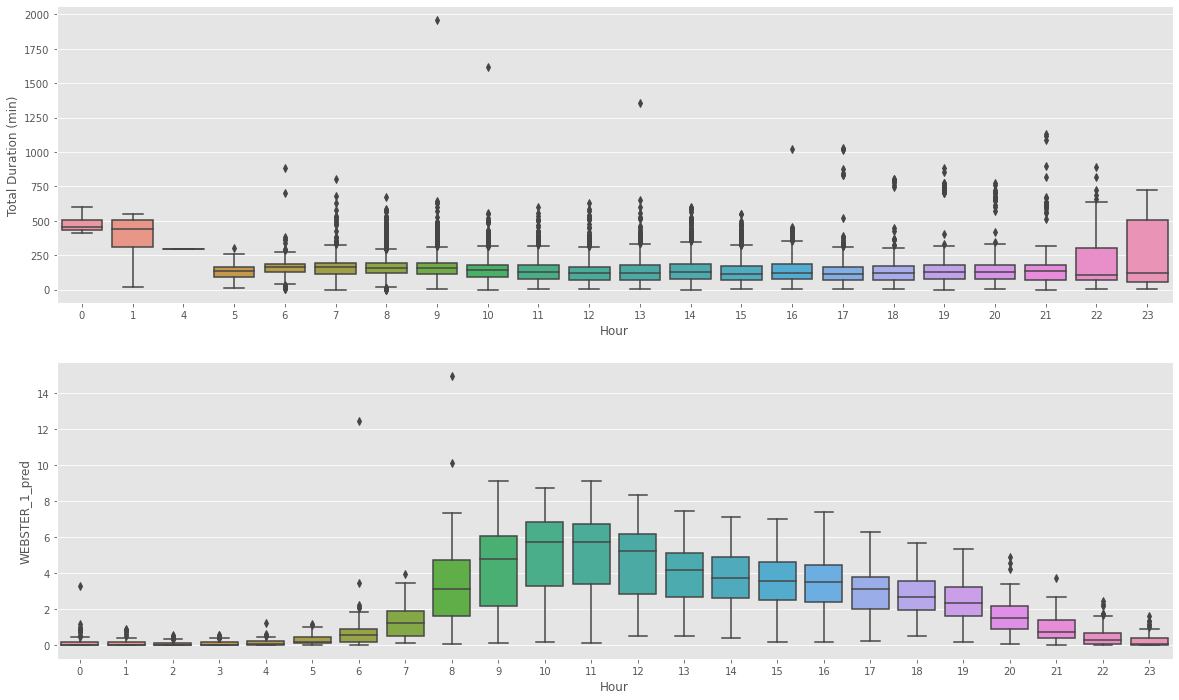

In [63]:
fig, axes = plt.subplots(2, figsize=(20,12))
sns.boxplot(data=df_webster, x="Hour", y="Total Duration (min)", ax = axes[0])
sns.boxplot(data=pred_webster, x="Hour", y="WEBSTER_1_pred", ax = axes[1])

In [65]:
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt

cluster_name = 'WEBSTER'
day_of_week_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']



def plot_histogram_hour(hour, day_of_week):
    fig, axs = plt.subplots(figsize=(12, 8))
    time_specific_df = pred_webster[(pred_webster['DayOfWeek'] == day_of_week) & (pred_webster['Hour'] == hour)]
    bins = range(0, int(time_specific_df[cluster_name + '_1_pred' ].max()) + 2)
    axs.hist(time_specific_df[cluster_name + '_1_pred'], density=True, edgecolor='black', linewidth=1.2, bins=list(bins))
    # make x axis integer
    axs.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    axs.set_title(f'Predidctions on {day_of_week_list[day_of_week]} {hour}')
    plt.show()

hour_intervals = list(range(24))# [f'{hour:1d}' for hour in range(24)]
hour_widget = widgets.SelectionSlider(
    options=hour_intervals,
    value=0,
    description='Hour:',
    disabled=False,
    continuous_update=True,
)

day_of_week_intervals = list(range(7))
day_of_week_widget = widgets.SelectionSlider(
    options=day_of_week_intervals,
    value=0,
    description='Day of week:',
    disabled=False,
    continuous_update=True,
)

widgets.interact(plot_histogram_hour, hour=hour_widget, day_of_week=day_of_week_widget)

interactive(children=(SelectionSlider(description='Hour:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, …

<function __main__.plot_histogram_hour(hour, day_of_week)>

In [82]:

webster_hourly_pluginTime = df_webster.groupby('Hour').mean().reset_index(drop = False)['Total Duration (min)']
webster_hourly_prediction = pred_webster.groupby('Hour').mean().reset_index(drop = False)['WEBSTER_1_pred']

webster_hourly_pluginTime = webster_hourly_pluginTime.iloc[8:21]
webster_hourly_prediction = webster_hourly_prediction.iloc[8:21]

#### Apply to queue

In [88]:
def mmc_queue(lambd, mu, c, num_customers, seed=None):
    random.seed(seed)  # Set seed for reproducibility
    interarrival_times = np.random.exponential(1/lambd, num_customers)
    service_times = np.random.exponential(1/mu, num_customers)

    arrival_times = np.cumsum(interarrival_times)
    departure_times = np.zeros(num_customers)
    queue_length = []
    queue = deque()  # Create an empty queue
    completed_customers = []

    for i in range(num_customers):
        arrival_time = arrival_times[i]
        service_time = service_times[i]

        # Check if a server is available
        queue_length.append(len(queue))
        if len(queue) < c:
            if arrival_time > departure_times[i-1]:
                departure_time = arrival_time + service_time
            else:
                departure_time = departure_times[i-1] + service_time

            departure_times[i] = departure_time
            queue.append(departure_time)
        else:
            departure_time = queue.popleft()
            if arrival_time > departure_time:
                departure_time = arrival_time + service_time
            else:
                departure_time += service_time
            departure_times[i] = departure_time
            queue.append(departure_time)

        completed_customers.append((arrival_time, departure_time))

    return completed_customers, queue_length

# Example usage
lambd =  1/webster_hourly_pluginTime[13]  # arrival time np.random.choice(webster_hourly_pluginTime, 1)[0]
mu =   1/webster_hourly_pluginTime[13] # service time  np.random.choice(webster_hourly_pluginTime, 1)[0]  
c = 4  # Number of servers
num_customers = 100  # Number of customers to simulate

completed_customers, queue_length = mmc_queue(lambd, mu, c, num_customers)

# Print arrival and departure times for each customer
for i, customer in enumerate(completed_customers):
    arrival_time, departure_time = customer
    print(f"Customer {i+1}: Arrival time={arrival_time:.2f}, Departure time={departure_time:.2f}")

Customer 1: Arrival time=22.53, Departure time=66.12
Customer 2: Arrival time=54.31, Departure time=141.32
Customer 3: Arrival time=75.69, Departure time=179.56
Customer 4: Arrival time=218.95, Departure time=226.62
Customer 5: Arrival time=412.16, Departure time=597.11
Customer 6: Arrival time=464.04, Departure time=618.58
Customer 7: Arrival time=465.14, Departure time=770.13
Customer 8: Arrival time=635.67, Departure time=652.22
Customer 9: Arrival time=905.43, Departure time=947.50
Customer 10: Arrival time=1126.81, Departure time=1171.55
Customer 11: Arrival time=1157.55, Departure time=1202.29
Customer 12: Arrival time=1205.93, Departure time=1289.84
Customer 13: Arrival time=1244.57, Departure time=1341.11
Customer 14: Arrival time=1399.96, Departure time=1605.46
Customer 15: Arrival time=1586.41, Departure time=1777.76
Customer 16: Arrival time=1704.09, Departure time=1745.87
Customer 17: Arrival time=1891.06, Departure time=2113.77
Customer 18: Arrival time=1914.22, Departure 

In [89]:
queue_length

[0,
 1,
 2,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4]

#### Dates for train/val/test split

In [104]:
from sklearn.model_selection import train_test_split

df_sessions = pd.read_csv('../data/charging_session_count_1_to_30_censored_1.csv')
df_sessions = df_sessions[df_sessions['Period'] >= '2017-01-01']
X_train, X_test, y_train, y_test  = train_test_split(df_sessions, df_sessions, test_size=0.3, shuffle = False)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.33, shuffle=False) # 0.25 x 0.8 = 0.2

In [105]:
X_train

,Period,BRYANT,CAMBRIDGE,HAMILTON,HIGH,MPL,RINCONADA,TED,WEBSTER,BRYANT_TAU,...,TED_TAU,WEBSTER_TAU,BRYANT_TRUE,CAMBRIDGE_TRUE,HAMILTON_TRUE,HIGH_TRUE,MPL_TRUE,RINCONADA_TRUE,TED_TRUE,WEBSTER_TRUE
95144,2017-01-01 00:00:00,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,2.0
95145,2017-01-01 00:30:00,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,2.0
95146,2017-01-01 01:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0
95147,2017-01-01 01:30:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
95148,2017-01-01 02:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123990,2018-08-24 23:00:00,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
123991,2018-08-24 23:30:00,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0
123992,2018-08-25 00:00:00,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
123993,2018-08-25 00:30:00,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [106]:
X_test

,Period,BRYANT,CAMBRIDGE,HAMILTON,HIGH,MPL,RINCONADA,TED,WEBSTER,BRYANT_TAU,...,TED_TAU,WEBSTER_TAU,BRYANT_TRUE,CAMBRIDGE_TRUE,HAMILTON_TRUE,HIGH_TRUE,MPL_TRUE,RINCONADA_TRUE,TED_TRUE,WEBSTER_TRUE
138206,2019-06-17 03:00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
138207,2019-06-17 03:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138208,2019-06-17 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138209,2019-06-17 04:30:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
138210,2019-06-17 05:00:00,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156657,2020-07-05 12:30:00,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,8.0,0.0,1.0,0.0,0.0,0.0,1.0
156658,2020-07-05 13:00:00,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,0.0,6.0,0.0,1.0,1.0,1.0,0.0,1.0
156659,2020-07-05 13:30:00,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,4.0,0.0,1.0,1.0,1.0,1.0,2.0
156660,2020-07-05 14:00:00,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,3.0,0.0,1.0,1.0,1.0,1.0,2.0


In [107]:
X_val

,Period,BRYANT,CAMBRIDGE,HAMILTON,HIGH,MPL,RINCONADA,TED,WEBSTER,BRYANT_TAU,...,TED_TAU,WEBSTER_TAU,BRYANT_TRUE,CAMBRIDGE_TRUE,HAMILTON_TRUE,HIGH_TRUE,MPL_TRUE,RINCONADA_TRUE,TED_TRUE,WEBSTER_TRUE
123995,2018-08-25 01:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
123996,2018-08-25 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
123997,2018-08-25 02:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
123998,2018-08-25 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
123999,2018-08-25 03:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138201,2019-06-17 00:30:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
138202,2019-06-17 01:00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
138203,2019-06-17 01:30:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
138204,2019-06-17 02:00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
